In [2]:
pip install biopython

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [68]:
from Bio import SearchIO, SeqIO, AlignIO
import matplotlib.pyplot as plt
import pandas as pd

# Objetivo 2
## 1a) Histograma de puntajes de dominio.

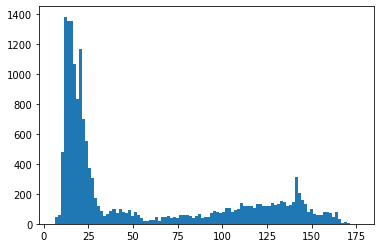

In [4]:
resultados = list(SearchIO.read("busqueda.out", "hmmer3-text"))

puntajes_lista = []
for seq in resultados:
    for dom in seq:
        puntajes_lista.append(dom.bitscore)
histogram = plt.hist(puntajes_lista, bins=100)
plt.show()

## 1b)
Desarrolle en python un código que utilice el puntaje de corte recién
establecido (esto debe ser un parámetro) para extraer los dominios búscados en las
secuencias correspondientes.
El mismo debe devolver un archivo fasta con dichas secuencias recortadas.
El código debe tener ademàs las dos siguientes funciones:
i) Debe ser capaz de obtener los Uniprot IDs y las posiciones de inicio y fin de los dominios
y entregar los resultados como lista de listas (o una matriz de numpy o pandas),
ii) Tomar los valores de la lista anterior (IDs y posiciones), y usarlos para cortar las
secuencias del registro fasta original.

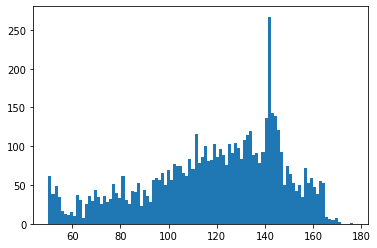

[('A0A3E0RFZ9',
  36,
  190,
  176.5,
  'tr|A0A3E0RFZ9|A0A3E0RFZ9_9BACL',
  'QSELARQLSMIYLTEEDLAVVKALQPLIAQHIDNIVDSFYDKLEQEPKLMSIIENKSSIERLKQTLRRHIQEMFNGRIDAAYIEQRRRIAIVHVNIGLEPKWYIGSFQNLLASLIEIMDDAIADKQDFVRAVTVVTKLLNIEQQLVLEEYENEH'),
 ('D3FSA7',
  32,
  185,
  171.1,
  'tr|D3FSA7|D3FSA7_BACPE',
  'PEVALQLKMIHLTKEDLVRIKAIQPLIHEHIEEIVDNFYKNLYQNPALTTIIEDHSSVDRLKKTLNRHIEEMFAGKMDAAYVEQRNRIAHVHVKIGLEPKWYMCAFQDLYTSIAVMIKEHAVDTSECLDAMLSVSKILNIEQQLVLEAYENEN'),
 ('U6SS08',
  34,
  187,
  171.1,
  'tr|U6SS08|U6SS08_9BACI',
  'PEVALQLKMIHLTKEDLVRIKAIQPLIHEHIEEIVDNFYKNLYQNPALTTIIEDHSSVDRLKKTLNRHIEEMFAGKMDAAYVEQRNRIAHVHVKIGLEPKWYMCAFQDLYTSIAVMIKEHAVDTSECLDAMLSVSKILNIEQQLVLEAYENEN'),
 ('A0A0K9H8Z2',
  32,
  185,
  169.8,
  'tr|A0A0K9H8Z2|A0A0K9H8Z2_9BACI',
  'GSLMNQLDMIGLTEKDLAIVKTLQPLVEEHLDDIVTTFYDAVGKQPNLLKIIEDHSSVNRLKKTLRQHIQELFNGEIDEEFIQKRLRIAYVHVRIGLKTKWYMSAFQELFNSLIALISEQDKTTAEKIQAISSVSKLLNLEQQLVLEAYEKEE'),
 ('G0RZQ1',
  19,
  200,
  169.8,
  'tr|G0RZQ1|G0RZQ1_CHATD',
  'TNLEARIRYLHSFLDFGTNDIE

In [81]:
def doms(archivo, bitscore_corte, plot=False):
    """ doms recibe un archivo de hmmsearch, un bitscore de corte y devuelve
    lista de tuplas (UniProtID, start pos, end pos, bitscore, FASTA ID, secuencia original)
    """
    resultados = list(SearchIO.read(archivo, "hmmer3-text"))
    records = SeqIO.index("globin_full_sequences.fasta", "fasta")
    
    doms_corte = []
    for seq in resultados:
        for dom in seq:
          if dom.bitscore > bitscore_corte:
            doms_corte.append((seq.id.split("|")[1],
                               dom.hit_start,
                               dom.hit_end,
                               dom.bitscore,
                               dom.hit_id,
                               str(records[dom.hit_id].seq[dom.hit_start-1:dom.hit_end-1])
                              ))


    if plot:
        histogram = plt.hist([d[3] for d in doms_corte], bins=100)
        plt.show()
    return doms_corte

ds = doms("busqueda.out", 50, plot=True)
ds

## 1c) Responda:

¿Cuántos dominios de protoglobina logró recuperar de la minería de datos?

In [61]:
len(ds)

5888

¿Puede afirmar que recuperó todos y que no dejó alguno afuera?
¿O que solo recuperó dominios protoglobina y que no incorporó dominios globina de otro
tipo? ¿Por qué?

Puede que no se hayan recuperado todos, dado que el punto de corte por bitscore fue elegido "a ojo" sobre el histograma de la totalidad de los hits. Estos serian los falsos negativos.

Dado que los modelos ocultos de Markov admiten cierta flexibilidad, puede que incluso por encima del umbral haya dominios que resulten muy similares al de protoglobina, siendo esto los falsos positivos.

# Objetivo 3

Ejercicio 3a) Parsee los MSAs hechos con hmmalign y MAFFT y busque la posición de la
histidina F8 (el residuo más conservado y característico de todas las globinas), y calcule la
proporción de gaps en el MSA para esa posición. (sugerencia: busque una columna en el
MSA donde la histidina representa más del 80% de los aminoácidos presentes en esa
columna).
Compare el porcentaje de histidinas en esa columna entre los dos MSAs obtenidos (por
MAFFT y hmmalign), y la proporción de gaps obtenida. ¿En qué posición está la histidina F8
en cada MSA? ¿Está en la misma posición en ambos casos? ¿En cuál MSA hay más
presencia de gaps?

In [63]:
# Guardar dominios en un FASTA
with open("doms.fasta", "w") as f:
    for dom in ds:
        hit_id, seq = dom[4], dom[5]
        f.write(">"+hit_id+"\n")
        f.write(seq+"\n")

In [ ]:
# $ mafft doms.fasta > doms_mafft_align.fasta
# $ hmmalign -o doms_hmmalign.sto PF11563.hmm doms.fasta

In [76]:
# MAFFT

align = AlignIO.read("doms_mafft_align.fasta", "fasta")
pos = 372

align_pd=pd.DataFrame(align)
align_pd[pos-1].value_counts(normalize=True) # en el dataframe la posicion es zero-indexed

H    0.913553
E    0.031420
-    0.020211
F    0.009511
Y    0.006114
A    0.004755
L    0.003227
R    0.002378
Q    0.002208
N    0.002208
M    0.001868
S    0.001019
C    0.000510
P    0.000510
T    0.000170
D    0.000170
V    0.000170
Name: 371, dtype: float64

In [77]:
# hmmalign
align = AlignIO.read("doms_hmmalign.sto", "stockholm")
pos = 260

align_pd=pd.DataFrame(align)
align_pd[pos-1].value_counts(normalize=True)

H    0.912194
E    0.031420
-    0.019192
F    0.010020
Y    0.005944
A    0.005265
L    0.003227
R    0.002548
Q    0.002548
N    0.002208
M    0.002038
S    0.001019
C    0.000679
P    0.000510
I    0.000340
V    0.000340
K    0.000340
D    0.000170
Name: 259, dtype: float64

¿En qué posición está la histidina F8
en cada MSA? ¿Está en la misma posición en ambos casos? ¿En cuál MSA hay más
presencia de gaps?

La histidina F8 están en posiciones distintas. En el caso con MAFFT está en la posición 372 del alineamiento, mientras que el alineamiento realizado con hmmalign dicha histidina se encuentra en posición 260.

La proporción de gaps es bastante comparable en ambos casos, pero para dicha posición en el alineamiento con MAFFT es levemente mayor.

## Ejercicio 3b Minería de datos.
PFAM posee en su base de datos 3 dominios globina, el ya utilizado protoglobina, y los
denominados “Globin” y “Bac_globin”.
1) Descargue los seeds de las éstas dos familias de globinas en Pfam, genere los HMM y
corra hmmsearch con cada HMM nuevo contra el set de globinas.
2) Genere los histogramas de puntaje de dominio y establezca un umbral de corte para
luego extraer los dominios.
3) Compare los 3 sets obtenidos. Hay alguna secuencia presente en más de un set? (use
los Uniprot ID de las secuencias para buscar coincidencias entre los sets)

4) Corra cada HMM contra cada set de dominios obtenidos (si son 3 HMM y 3 sets de
dominios recuperados, son un total de 9 corridas de hmmsearch).
5) Usando los resultados de búsqueda de 4) genere histogramas de distribución de puntaje
para cada HMM (para cada set de secuencias use un color distinto). A modo de ejemplo:

¿Observa algún solapamiento entre las curvas? ¿Cómo lo interpretaría? ¿Fue buena la
separación que hizo?